In [25]:
import matplotlib.pyplot as plt
import numpy as np
import emcee
import corner
import scipy.stats
from scipy.stats import bernoulli
import tqdm

thefigsize = (5,5)
intcnt = 50
tt = 500

I have discussed and consulted this homework assignment with Mengjian Hua. 

In [26]:
# function registerations
def cal_energy(x):
    return (100*((x[1]-x[0]**2)**2)+(1-x[0])**2)/20

def cal_hessian(x):
    H = np.zeros((2,2))
    H[0,0] = -20*x[1]+60*(x[0]**2) + 1/10
    H[1,0] = -20*x[0]
    H[0,1] = H[1,0]
    H[1,1] = 10
    return H

def cal_energy_grad(x):
    grad = np.zeros(2)
    grad[0] = -20*(x[1]-x[0]**2)*x[0]+(x[0]-1)/10
    grad[1] = 10*(x[1]-x[0]**2)
    return grad

def sqrt_mat(S):
    detval = np.linalg.det(S)
    if np.all(np.linalg.eigvals(S)>0):
        R = (S+np.sqrt(detval)*np.eye(2))/np.sqrt(np.trace(S)+2*np.sqrt(detval))
    else:
        R = (S+np.sqrt(np.abs(detval))*np.eye(2))/np.sqrt(np.abs(np.trace(S)+2*np.sqrt(np.abs(detval))))
    return R

# the default parameter settings are suggested by Mengjian Hua
def stochastic_newton(x,numsteps=10000,h=1e-4):
    f = np.zeros(numsteps)
    allx = np.zeros((numsteps,2))
    rej = 0
    for i in range(numsteps):
        energy_grad = cal_energy_grad(x)
        hessian = cal_hessian(x)
        rrg = np.random.normal(size=2)
        oldx = x
        h_inv = np.linalg.inv(hessian)
        h_inv_sqrt = sqrt_mat(h_inv)
        x = x - np.matmul(h_inv,energy_grad)*h+np.matmul(h_inv_sqrt*np.sqrt(2*h),rrg)
        q1 = np.exp(-np.sum(np.sqrt(2*h)*rrg*np.matmul(hessian,rrg))/4/h)
        q2v = oldx-x+np.matmul(h_inv,cal_energy_grad(x))*h
        q2 = np.exp(-np.sum(q2v*np.matmul(hessian,q2v))/4/h)
        p_acc = min(1,q2*np.exp(-cal_energy(x))/np.exp(-cal_energy(oldx))/q1)
        udist = np.random.uniform(1)
        if p_acc < udist:
            x = oldx
            rej += 1
        f[i] = x[0]
        allx[i,:] = x
    acc = 1-rej/numsteps
    return allx,acc

def metropolized_overdamped(x,numsteps=10000,h=1e-2):
    f = np.zeros(numsteps)
    allx = np.zeros((numsteps,2))
    rej = 0
    for i in range(numsteps):
        energy_grad = cal_energy_grad(x)
        rrg = np.random.normal(size=2)
        oldx = x
        x = x-energy_grad*h+np.sqrt(2*h)*rrg
        q1 = np.exp(-np.sum(rrg**2))
        q2 = np.exp(-np.sum((cal_energy_grad(oldx)*h+cal_energy_grad(x)*h-np.sqrt(2*h)*rrg)**2)/4/h)
        p_acc = min(1,q2*np.exp(-cal_energy(x))/np.exp(-cal_energy(oldx))/q1)
        udist = np.random.uniform(1)
        if p_acc < udist:
            x = oldx
            rej += 1
        f[i] = x[0]
        allx[i,:] = x
    acc = 1-rej/numsteps
    return allx,acc

def sample_g(a):
    val = ((np.sqrt(a)-np.sqrt(1/a))*np.random.uniform()+np.sqrt(1/a))**2
    return val

def affine_invarient(N=10,numsteps=2000,alpha=2):
    f = np.zeros(numsteps)
    x = np.random.randn(N,2)
    allx = np.zeros((N,2,numsteps))
    accval = 0
    for k in range(numsteps):
        for i in range(N):
            randval = np.random.randint(N-1,size=1)+1
            j = (i-randval).astype(int)
            Z = sample_g(alpha)
            Y = np.squeeze(x[j,:]+Z*(x[i,:]-x[j,:]))
            tem = 1/np.sqrt(Z)
            teminv = 1/np.sqrt(1/Z)
            p_acc = min(1,teminv*np.exp(-cal_energy(Y))/np.exp(-cal_energy(x[i,:]))/tem)
            if p_acc > np.random.uniform():
                x[i,:] = Y
                accval = accval+1
            f[i] = np.sum(x[:,0])
        allx[:,:,k] = x
    allx = allx.swapaxes(1,2).reshape((N*numsteps,2))
    acc = accval/N/numsteps
    IAT = emcee.autocorr.integrated_time(f)
    return x,IAT,allx,acc

In [27]:
# experiments
cc = 11
kk = 100000
acset = np.zeros((cc))
IAT = np.zeros((cc))
Lall = np.linspace(10,50,cc)
for i in range(cc):
    x_e,IAT[i],x_e_all,acset[i] = affine_invarient(N=int(Lall[i]),numsteps=kk,alpha=2)

Text(0, 0.5, 'Acceptance Ratio')

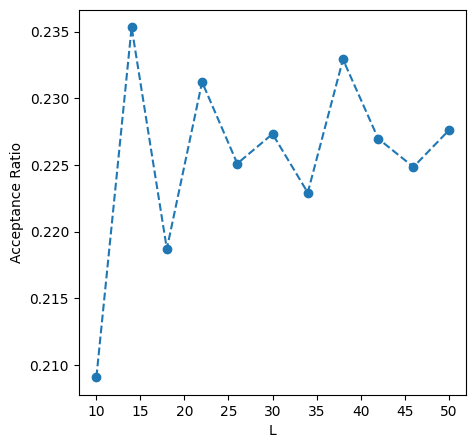

In [28]:
plt.figure(figsize=thefigsize)
plt.plot(Lall,acset,linestyle='--',marker='o')
plt.xlabel('L')
plt.ylabel('Acceptance Ratio')

In [29]:
cc = 11
kk = 100000
acset = np.zeros((cc))
IAT = np.zeros((cc))
alphaall = np.linspace(2,6,cc)
for i in range(cc):
    x_e,IAT[i],x_e_all,acset[i] = affine_invarient(N=10,numsteps=kk,alpha=alphaall[i])

Text(0, 0.5, 'Acceptance Ratio')

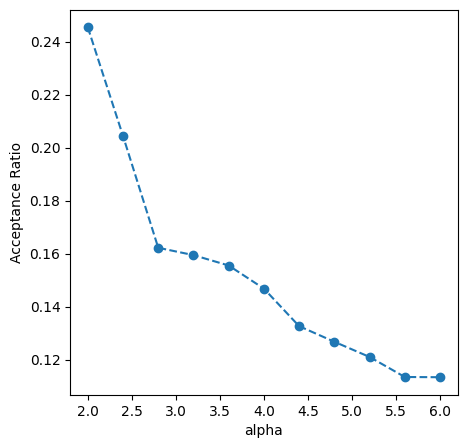

In [30]:
plt.figure(figsize=thefigsize)
plt.plot(alphaall,acset,linestyle='--',marker='o')
plt.xlabel('alpha')
plt.ylabel('Acceptance Ratio')

In [31]:
# experiments
kk = 1000000
cc = 5
h_all = 1/(10**(np.arange(0,cc)))

x_newton = np.array([0,0])
accept_newton = np.zeros((cc))
x_newton_all = np.zeros((kk,2,cc))
for i in range(cc):
    x_newton_all[:,:,i],accept_newton[i] = metropolized_overdamped(x_newton,numsteps=kk,h=h_all[i]) 


x_langevin = np.array([0,0])
accept_langevin = np.zeros((cc))
x_langevin_all = np.zeros((kk,2,cc))
for i in range(cc):
    x_langevin_all[:,:,i],accept_langevin[i] = metropolized_overdamped(x_langevin,numsteps=kk,h=h_all[i]) 

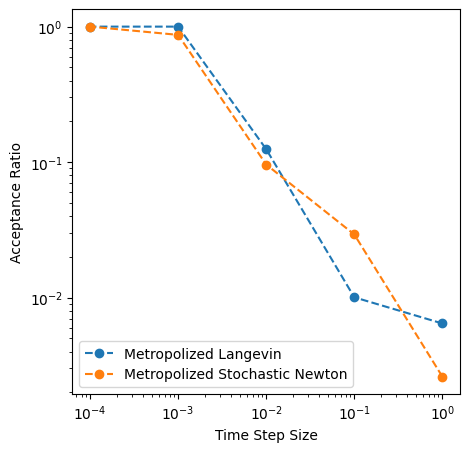

In [50]:
plt.figure(figsize=thefigsize)
plt.plot(h_all,accept_langevin,linestyle='--',marker='o',label='Metropolized Langevin')
plt.plot(h_all,accept_newton,linestyle='--',marker='o',label='Metropolized Stochastic Newton')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time Step Size')
plt.ylabel('Acceptance Ratio')
plt.legend()

Text(0.5, 1.0, 'langevin')

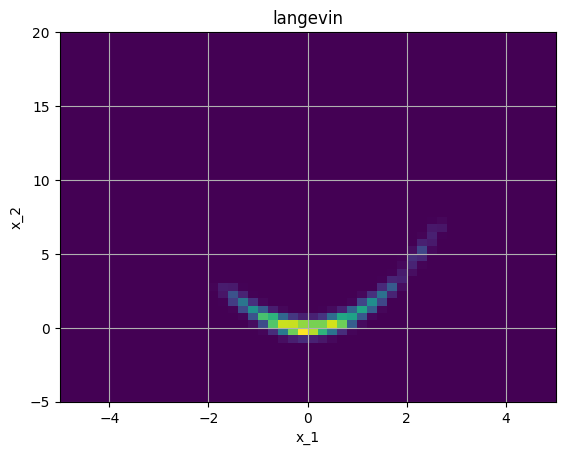

In [51]:
# langevin
plt.hist2d(np.squeeze(x_langevin_all[:,0,-1]),np.squeeze(x_langevin_all[:,1,-1]),range=[[-5,5],[-5,20]],bins=50)
plt.grid()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('langevin')

Text(0.5, 1.0, 'newton')

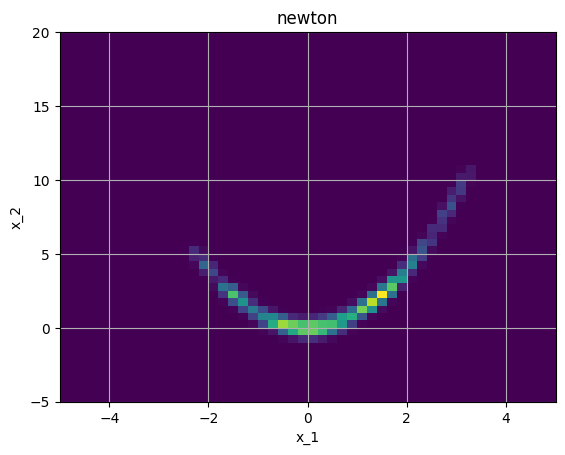

In [52]:
plt.hist2d(np.squeeze(x_newton_all[:,0,-1]),np.squeeze(x_newton_all[:,1,-1]),range=[[-5,5],[-5,20]],bins=50)
plt.grid()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('newton')

Text(0.5, 1.0, 'affine')

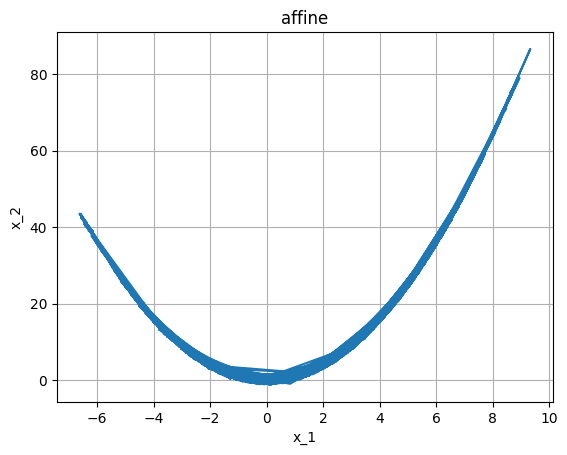

In [53]:
plt.plot(x_e_all[:,0],x_e_all[:,1])
plt.grid()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title('affine')